## Part 1: Data Modelling and ELT

It consists of three csv files: trades, containing data on executed trades, prices, the respective end of day prices, and instruments, which contains data on the index the instrument belongs to, as well as its type, country, and sector.

In [228]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statistics
from statistics import median

In [229]:
#import datasets

instruments = pd.read_csv('instruments.csv')
prices = pd.read_csv('prices.csv')
trades = pd.read_csv('trades.csv')


Around 105k data entries for each trade, from Jan to Dec 2020. Three different csv files are provided:

- trades: The document is composed by information on each trade. Customer_id, execution_time direction (BUY/SELL), execution_size (#shares), execution_price and instrument_id. 

- instruments: contains further information on each instrument traded. It allows the analyst to draw results and stats on types of instruments (e.g. Asset Type, Region, Country).

- prices: the respective end of day prices, for each day.

In [230]:
#quick look 
trades.head()

,Unnamed: 0,customer_id,execution_time,direction,execution_size,execution_price,instrument_id
0,0,4216,2020-01-02 20:00:00,BUY,1.0,8.49,59.0
1,1,1202,2020-01-06 11:00:00,BUY,10.0,8.92,59.0
2,2,4129,2020-01-07 18:00:00,BUY,4.0,8.90,59.0
3,3,4129,2020-01-07 18:00:00,SELL,4.0,8.88,59.0
4,4,4207,2020-01-20 10:00:00,BUY,1.0,8.83,59.0


In [231]:
instruments.head()

,instrument_id,sector_name,country_name,index_name,instrument_type
0,0,{Touristik},{Bermuda-Inseln},{SP500},STOCK
1,1,"{""""}","{""""}","{""""}",STOCK
2,2,{Genussmittel},{Kanada},"{""""}",STOCK
3,3,"{""Elektronik & Haushalt""}",{China},"{""""}",STOCK
4,4,{Finanzen},{Deutschland},{DAX},STOCK


In [232]:
#INSTRUMENTS DATA CLEANING 
instruments['sector_name'] = instruments['sector_name'].str.replace("{","").str.replace("}","")
instruments['country_name'] = instruments['country_name'].str.replace("{","").str.replace("}","")
instruments['index_name'] = instruments['index_name'].str.replace("{","").str.replace("}","")

instruments.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


,instrument_id,sector_name,country_name,index_name,instrument_type
0,0,Touristik,Bermuda-Inseln,SP500,STOCK
1,1,"""""","""""","""""",STOCK
2,2,Genussmittel,Kanada,"""""",STOCK
3,3,"""Elektronik & Haushalt""",China,"""""",STOCK
4,4,Finanzen,Deutschland,DAX,STOCK


In [233]:
#merge information from intruments on positions
trades_details = trades.merge(instruments, on='instrument_id')

In [234]:
#check data types for calculations
trades_details.dtypes

Unnamed: 0           int64
customer_id          int64
execution_time      object
direction           object
execution_size     float64
execution_price    float64
instrument_id      float64
sector_name         object
country_name        object
index_name          object
instrument_type     object
dtype: object

In [235]:
#check null values 

trades_details.isnull().sum()

Unnamed: 0         0
customer_id        0
execution_time     0
direction          0
execution_size     1
execution_price    1
instrument_id      0
sector_name        0
country_name       0
index_name         0
instrument_type    0
dtype: int64

In [236]:
#drop row with null size
trades_details = trades_details.dropna()

In [237]:
trades_details['direction'].unique()

array(['BUY', 'SELL'], dtype=object)

In [238]:
#calculte trade size (market value)
#if BUY --> increse account net asset value (positive value)
#if SELL --> decrese account net asset value (negative value)
trades_details['MV'] = np.where(trades_details['direction']=='BUY', 
                                trades_details['execution_size'] *trades_details['execution_price'],
                       - trades_details['execution_size'] *trades_details['execution_price'] )

In [239]:
#delete Unnamed: 0 columns (same as index)
trades_details.drop(['Unnamed: 0'], inplace= True, axis=1)

In [240]:
trades_details['abs MV'] = trades_details['MV'].abs()
trades_details.sort_values(by=['execution_time'], inplace = True)

In [241]:
#Compute the size per instrument and account 

positions = trades_details.groupby(['customer_id','instrument_id']).agg({'MV':'sum','abs MV':'sum',
                                                                         'execution_size': 'sum',
                                                                        'execution_price':'mean',
                                                                        'instrument_type':'first',
                                                                        'sector_name':'first',
                                                                        'country_name':'first',
                                                                        'index_name':'first'})

positions

MV    abs MV  execution_size  execution_price  \
customer_id instrument_id                                                       
1           7.0            656.305   656.305            27.0        23.552500   
            8.0            267.880   267.880            20.0        13.394000   
            19.0           500.340   500.340             5.0        99.630000   
            23.0           459.650   459.650             5.0        91.930000   
            28.0           -24.200   888.200             4.0       222.050000   
...                            ...       ...             ...              ...   
30000       591.0          -17.670   389.650             4.0        97.412500   
            593.0          221.590   985.390            11.0        91.081667   
            596.0          374.850   830.150            20.0        42.010000   
            614.0          190.160   562.240             3.0       187.413333   
            621.0           -1.000  1575.800             4.0       393.950000   

                          instrument_type         sector_name country_name  \
customer_id instrument_id                                                    
1           7.0                     STOCK           Transport  Deutschland   
            8.0                     STOCK             Telekom  Deutschland   
            19.0                    STOCK            Software  Deutschland   
            23.0                    STOCK            Software  Deutschland   
            28.0                    STOCK        Versicherung  Deutschland   
...                                   ...                 ...          ...   
30000       591.0                   STOCK            Computer          USA   
            593.0                   STOCK  Biotech,Gesundheit  Deutschland   
            596.0                   STOCK        Genussmittel          USA   
            614.0                   STOCK            Finanzen          USA   
            621.0                   STOCK                Auto          USA   

                                       index_name  
customer_id instrument_id                          
1           7.0                   DAX,EUROSTOXX50  
            8.0            DAX,EUROSTOXX50,TecDAX  
            19.0           DAX,EUROSTOXX50,TecDAX  
            23.0                               ""  
            28.0                  DAX,EUROSTOXX50  
...                                           ...  
30000       591.0           DowJones,NASDAQ,SP500  
            593.0                              ""  
            596.0                  DowJones,SP500  
            614.0                    NASDAQ,SP500  
            621.0                          NASDAQ  

[263754 rows x 8 columns]

In [242]:
positions['L/S'] = np.where(positions['MV']>0, 'Long', 'Short')
positions

MV    abs MV  execution_size  execution_price  \
customer_id instrument_id                                                       
1           7.0            656.305   656.305            27.0        23.552500   
            8.0            267.880   267.880            20.0        13.394000   
            19.0           500.340   500.340             5.0        99.630000   
            23.0           459.650   459.650             5.0        91.930000   
            28.0           -24.200   888.200             4.0       222.050000   
...                            ...       ...             ...              ...   
30000       591.0          -17.670   389.650             4.0        97.412500   
            593.0          221.590   985.390            11.0        91.081667   
            596.0          374.850   830.150            20.0        42.010000   
            614.0          190.160   562.240             3.0       187.413333   
            621.0           -1.000  1575.800             4.0       393.950000   

                          instrument_type         sector_name country_name  \
customer_id instrument_id                                                    
1           7.0                     STOCK           Transport  Deutschland   
            8.0                     STOCK             Telekom  Deutschland   
            19.0                    STOCK            Software  Deutschland   
            23.0                    STOCK            Software  Deutschland   
            28.0                    STOCK        Versicherung  Deutschland   
...                                   ...                 ...          ...   
30000       591.0                   STOCK            Computer          USA   
            593.0                   STOCK  Biotech,Gesundheit  Deutschland   
            596.0                   STOCK        Genussmittel          USA   
            614.0                   STOCK            Finanzen          USA   
            621.0                   STOCK                Auto          USA   

                                       index_name    L/S  
customer_id instrument_id                                 
1           7.0                   DAX,EUROSTOXX50   Long  
            8.0            DAX,EUROSTOXX50,TecDAX   Long  
            19.0           DAX,EUROSTOXX50,TecDAX   Long  
            23.0                               ""   Long  
            28.0                  DAX,EUROSTOXX50  Short  
...                                           ...    ...  
30000       591.0           DowJones,NASDAQ,SP500  Short  
            593.0                              ""   Long  
            596.0                  DowJones,SP500   Long  
            614.0                    NASDAQ,SP500   Long  
            621.0                          NASDAQ  Short  

[263754 rows x 9 columns]

In [243]:
positions['instrument_type'].unique()

array(['STOCK', 'DERIVATIVE', 'ETF'], dtype=object)

##### Assumptions and Notes:

- Long vs Short Positions
Short positions are included in this analysis and calculated with negative values. Short positions and borrowings are considered negative values and therefore carry a negative weight to the portfolio size.

- Size definition
In order to answer the first question, "how big is each account", I have decided to compute the value in market value terms (local currency). Example: value = price * quantity 

Assumption: prices are assumed to be in EUR.

#### 1st QUESTION: How big is the portfolio of each account?


In [244]:
account_size = positions.groupby('customer_id')['MV'].agg('sum').sort_values(ascending = False)
account_size

customer_id
27631    359118.834000
1251     336458.101444
6039     276439.600000
18894    274725.948000
2887     273142.345000
             ...      
4821     -35222.525458
7855     -35451.589916
8368     -41670.610000
2036     -44970.559000
1903     -73176.790000
Name: MV, Length: 29096, dtype: float64

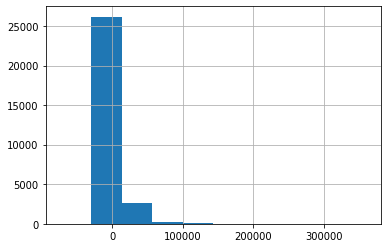

In [245]:
account_size.hist()

In [246]:
account_size.describe()

count     29096.000000
mean       5318.271360
std       12456.062222
min      -73176.790000
25%         373.853750
50%        1708.801351
75%        5435.446937
max      359118.834000
Name: MV, dtype: float64

Text(0.5, 1.0, 'Account Size Distribution (EUR)')

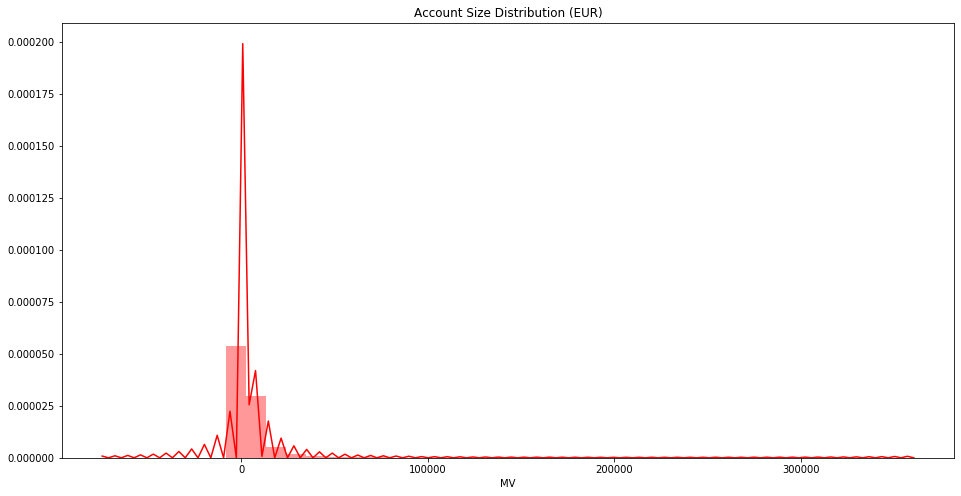

In [275]:
plt.figure(figsize=(16,8))
sns.distplot(account_size, color='red', bins=40)
plt.title("Account Size Distribution (EUR)")

#### 2nd QUESTION: What is its distribution over different instrument types?


In [248]:
byinstrument  = positions.pivot_table(index='customer_id', columns='instrument_type', values= 'abs MV',
                        aggfunc=sum,fill_value=0)

#compute function to calculate percentage weights (might be useful later)
def percentage_calc(df):
    percentage_df = pd.DataFrame([])
    
    for column in df.columns:
        percentage_df[column] = df[column]/df.sum(axis=1)
    return percentage_df
    
    
byinstrument_perc = percentage_calc(byinstrument)

byinstrument_perc.loc["Average"] = byinstrument_perc.mean()
byinstrument_perc

,DERIVATIVE,ETF,STOCK
customer_id,,,
1,0.000000,0.000000,1.000000
2,0.047785,0.772862,0.179353
3,0.000000,0.567986,0.432014
4,0.000000,0.205144,0.794856
5,0.000000,0.053627,0.946373
...,...,...,...
29997,0.000000,0.717070,0.282930
29998,0.000000,0.000000,1.000000
29999,0.443732,0.009369,0.546899


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until


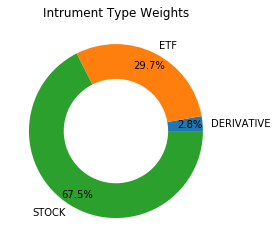

In [249]:
# Create a pieplot
plt.pie(byinstrument_perc.tail(1), labels=byinstrument_perc.columns,
        autopct='%1.1f%%', pctdistance=0.85)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title("Intrument Type Weights") 

plt.show()

### 3rd QUESTION: Are these accounts profitable?

Meaning, are these customers making money with their transactions?

We need to have by costumer, by instrument and day and then calculate interday performance of each instrument (use prices table)

In [250]:
#Remove traded hours

trades_details['execution_time'] = trades_details['execution_time'] .str[:10]

trades_details['execution_time'] = pd.to_datetime(trades_details['execution_time'])


In [251]:
#date to same format 
prices['date'] = pd.to_datetime(prices['date'])

In [252]:
trades_details.rename(columns={'execution_time': 'date'}, inplace=True)

In [253]:
new = pd.merge(trades_details,prices,how='inner',on=['instrument_id','date'])


In [254]:
#now I can calculate day performance 
new

,customer_id,date,direction,execution_size,execution_price,instrument_id,sector_name,country_name,index_name,instrument_type,MV,abs MV,price
0,3764,2020-01-02,BUY,303.0,1.2900,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,390.8700,390.8700,1.3600
1,4522,2020-01-02,BUY,30.0,1.2862,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,38.5860,38.5860,1.3600
2,2097,2020-01-02,BUY,20.0,1.2948,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,25.8960,25.8960,1.3600
3,4021,2020-01-02,BUY,40.0,1.2980,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,51.9200,51.9200,1.3600
4,410,2020-01-02,BUY,4.0,1.2978,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,5.1912,5.1912,1.3600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094031,15654,2020-12-30,SELL,50.0,3.5268,35.0,Rohstoffe,"""""","""""",ETF,-176.3400,176.3400,3.5241
1094032,21671,2020-12-30,BUY,7.0,3.5298,35.0,Rohstoffe,"""""","""""",ETF,24.7086,24.7086,3.5241
1094033,8049,2020-12-30,BUY,370.0,1.2700,532.0,"""""","""""","""""",DERIVATIVE,469.9000,469.9000,1.2500
1094034,1280,2020-12-30,BUY,1.0,1774.6000,595.0,"""Large Caps"",Touristik",USA,"""""",STOCK,1774.6000,1774.6000,1774.0600


In [255]:
#Compute the size per instrument, account and day

positions = new.groupby(['customer_id','instrument_id']).agg({'MV':'sum','abs MV':'sum',
                                                                         'execution_size': 'sum',
                                                                        'execution_price':'mean',
                                                                        'price':'last',
                                                                        'instrument_type':'first',
                                                                        'sector_name':'first',
                                                                        'country_name':'first',
                                                                        'index_name':'first'})

positions

MV    abs MV  execution_size  execution_price  \
customer_id instrument_id                                                       
1           7.0            656.305   656.305            27.0        23.552500   
            8.0            267.880   267.880            20.0        13.394000   
            19.0           500.340   500.340             5.0        99.630000   
            23.0           459.650   459.650             5.0        91.930000   
            28.0           -24.200   888.200             4.0       222.050000   
...                            ...       ...             ...              ...   
30000       591.0          -17.670   389.650             4.0        97.412500   
            593.0          221.590   985.390            11.0        91.081667   
            596.0          374.850   830.150            20.0        42.010000   
            614.0          190.160   562.240             3.0       187.413333   
            621.0           -1.000  1575.800             4.0       393.950000   

                             price instrument_type         sector_name  \
customer_id instrument_id                                                
1           7.0             21.200           STOCK           Transport   
            8.0             13.600           STOCK             Telekom   
            19.0            98.500           STOCK            Software   
            23.0            92.500           STOCK            Software   
            28.0           247.100           STOCK        Versicherung   
...                            ...             ...                 ...   
30000       591.0          279.700           STOCK            Computer   
            593.0           81.950           STOCK  Biotech,Gesundheit   
            596.0           45.555           STOCK        Genussmittel   
            614.0          196.600           STOCK            Finanzen   
            621.0          411.250           STOCK                Auto   

                          country_name              index_name  
customer_id instrument_id                                       
1           7.0            Deutschland         DAX,EUROSTOXX50  
            8.0            Deutschland  DAX,EUROSTOXX50,TecDAX  
            19.0           Deutschland  DAX,EUROSTOXX50,TecDAX  
            23.0           Deutschland                      ""  
            28.0           Deutschland         DAX,EUROSTOXX50  
...                                ...                     ...  
30000       591.0                  USA   DowJones,NASDAQ,SP500  
            593.0          Deutschland                      ""  
            596.0                  USA          DowJones,SP500  
            614.0                  USA            NASDAQ,SP500  
            621.0                  USA                  NASDAQ  

[262358 rows x 9 columns]

In [256]:
#PnL standing for Profit And Loss
#price at the end of the year vs average acquisition price of the holding 
#assumption: we should calculate average price with execution size weights, but for simplistic terms 

positions['pnl'] = (positions_time['price'] -positions_time['execution_price'])*positions_time['execution_size']

positions['performance'] = positions['pnl']/positions['abs MV']

In [257]:
positions.head()

MV   abs MV  execution_size  execution_price  \
customer_id instrument_id                                                      
1           7.0            656.305  656.305            27.0          23.5525   
            8.0            267.880  267.880            20.0          13.3940   
            19.0           500.340  500.340             5.0          99.6300   
            23.0           459.650  459.650             5.0          91.9300   
            28.0           -24.200  888.200             4.0         222.0500   

                           price instrument_type   sector_name country_name  \
customer_id instrument_id                                                     
1           7.0             21.2           STOCK     Transport  Deutschland   
            8.0             13.6           STOCK       Telekom  Deutschland   
            19.0            98.5           STOCK      Software  Deutschland   
            23.0            92.5           STOCK      Software  Deutschland   
            28.0           247.1           STOCK  Versicherung  Deutschland   

                                       index_name       pnl  performance  
customer_id instrument_id                                                 
1           7.0                   DAX,EUROSTOXX50  -63.5175    -0.096780  
            8.0            DAX,EUROSTOXX50,TecDAX    4.1200     0.015380  
            19.0           DAX,EUROSTOXX50,TecDAX   -5.6500    -0.011292  
            23.0                               ""    2.8500     0.006200  
            28.0                  DAX,EUROSTOXX50  100.2000     0.112812

In [258]:
#for each account check aggregated pnl


account_pnl = positions.groupby(['customer_id'])[['pnl', 'performance']].agg('sum').sort_values(by = 'performance',ascending = False)
account_pnl 

,pnl,performance
customer_id,,
8894,13502.867699,482.185173
18641,715.607838,289.410462
8689,69961.391830,234.969487
111,55267.026384,234.628520
17257,-9342.510333,215.425626
...,...,...
7915,-21691.324900,-15.487495
4320,-3642.694193,-17.197149
5948,-6175.264073,-20.247600


In [259]:
account_pnl['pnl'].describe()

count    2.909200e+04
mean     8.185660e+02
std      3.198223e+04
min     -2.314286e+06
25%     -1.543959e+02
50%      5.060717e+01
75%      6.263985e+02
max      1.197891e+06
Name: pnl, dtype: float64

In [260]:
account_pnl_no_outliers = account_pnl[account_pnl['performance']<100]

In [261]:
#removing outliers 

Text(0.5, 1.0, 'Performance Distribution')

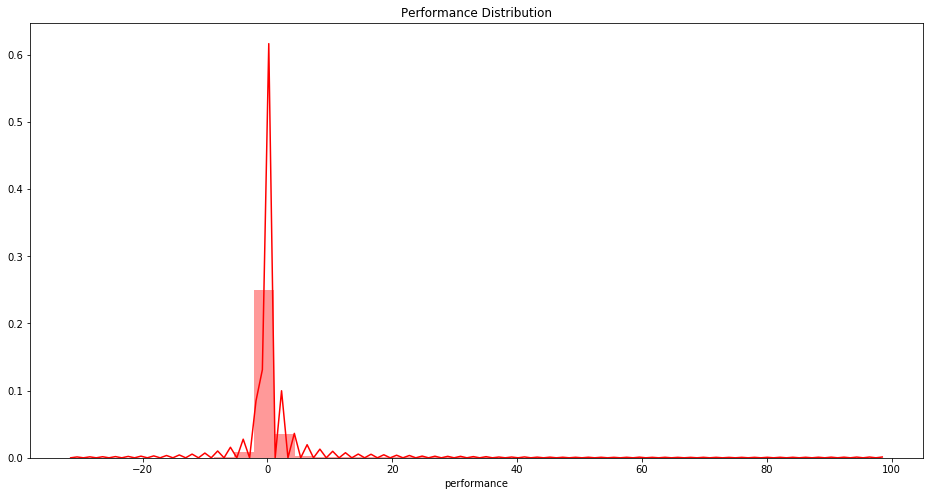

In [262]:
plt.figure(figsize=(16,8))
sns.distplot(account_pnl_no_outliers['performance'], color='red', bins=40)
plt.title("Performance Distribution")

### 4th QUESTION: Aditional Business Insights?

In [263]:
#Long vs Short Positions
positions['L/S'] = np.where(positions['MV']>0, 'Long', 'Short')
byLS = positions.pivot_table(index='customer_id', columns='L/S', values= 'abs MV',
                        aggfunc=sum,fill_value=0)

byLS_perc = percentage_calc(byLS)

byLS_perc.loc["Average"] = byLS_perc.mean()
byLS_perc

,Long,Short
customer_id,,
1,0.923367,0.076633
2,0.197144,0.802856
3,0.840155,0.159845
4,1.000000,0.000000
5,0.924426,0.075574
...,...,...
29997,1.000000,0.000000
29998,1.000000,0.000000
29999,0.688576,0.311424


Text(0.5, 1.0, 'Average L/S weights')

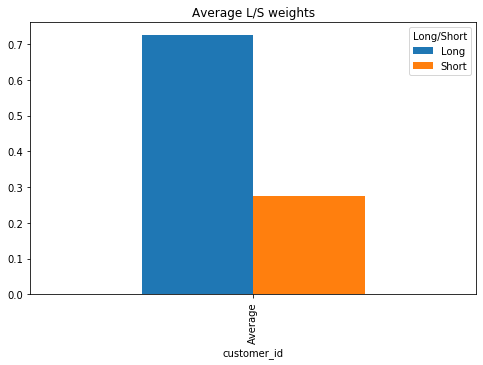

In [264]:
byLS_perc.tail(1).plot.bar(figsize=(8,5))

plt.legend(title='Long/Short')
plt.title('Average L/S weights')

###### Sectors:

As it can be seen below it would require some data cleaning to check the below: all names in English (several are in German), what to do with Large/Mid/Small Caps as this is not sector wise but market capitalization size of the company

In [265]:
positions['sector_name'].unique()

array(['Transport', 'Telekom', 'Software', 'Versicherung', 'Chemie',
       'Beteiligung', 'Luftfahrt', 'Halbleiter', 'Computer', 'Nahrung',
       'Finanzen', '"Elektronik & Haushalt"', '""', '"Öl & Gas"',
       '"Large/Mid Caps"', '"Large/Mid/Small Caps"',
       'Computer,"Elektronik & Haushalt","Large Caps"', 'Mining',
       '"Large Caps"', 'Energieversorgung',
       '"Large/Mid Caps","Mehrere Sektoren"', 'Biotech,Gesundheit',
       'Pharma', 'Industrie', 'Auto', '"Dienstleistungen Diverse"',
       'Sonstige', '"Mid Caps"', 'Computer,Software,Sonstige',
       'Touristik', 'Computer,Software', 'Gesundheit', 'Biotech',
       'Rohstoffe', 'Genussmittel', '"Handelsfirmen Diverse"',
       'Software,Telekom', 'Bauen', 'Gesundheit,"Mid Caps"',
       '"Large Caps","Mehrere Sektoren"', 'Immobilien', 'Auto,Sonstige',
       'Genussmittel,Kleidung', '"Large/Mid Caps","Large/Mid/Small Caps"',
       '"Large Caps",Touristik', 'Konsum'], dtype=object)

In [62]:
bysector  = positions.pivot_table(index='customer_id', columns='sector_name', values= 'abs MV',
                        aggfunc=sum,fill_value=0)

    
bysector_perc = percentage_calc(bysector)

bysector_perc.loc["Average"] = bysector_perc.mean()
bysector_perc = bysector_perc.tail(1).T.sort_values(by=['Average'],ascending = False)
bysector_perc

customer_id,Average
Software,0.140776
"""Large/Mid Caps""",0.116910
"""""",0.068700
Luftfahrt,0.063617
Auto,0.057421
"""Large/Mid Caps"",""Mehrere Sektoren""",0.048943
"""Öl & Gas""",0.035837
"""Large/Mid/Small Caps""",0.032761
Computer,0.032218
"Biotech,Gesundheit",0.030152


In [64]:
#country

bycountry  = positions.pivot_table(index='customer_id', columns='country_name', values= 'abs MV',
                        aggfunc=sum,fill_value=0)

    
bycountry_perc = percentage_calc(bycountry)

bycountry_perc.loc["Average"] = bycountry_perc.mean()
bycountry_perc = bycountry_perc.tail(1).T.sort_values(by=['Average'],ascending = False)
bycountry_perc

customer_id,Average
"""""",0.379109
Deutschland,0.282110
USA,0.209074
China,0.044902
UK,0.034118
Niederlande,0.024981
Norwegen,0.019209
Bermuda-Inseln,0.003362
Frankreich,0.001273
Israel,0.001096


#### Time Series Analysis

In [66]:
#Compute the size per instrument and account - Average 

positions_date = trades_details.groupby(['date']).agg({'MV':'sum','abs MV':'sum',
                                                                         'execution_size': 'sum',
                                                                        'execution_price':'mean',
                                                                        'instrument_type':'first',
                                                                        'sector_name':'first',
                                                                        'country_name':'first',
                                                                        'index_name':'first'})

positions_date

,MV,abs MV,execution_size,execution_price,instrument_type,sector_name,country_name,index_name
date,,,,,,,,
2020-01-02,398499.347285,4.098365e+05,14586.5029,70.754489,STOCK,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,""""""
2020-01-03,198675.679000,2.348952e+05,11388.0000,92.306821,STOCK,"""""","""""",""""""
2020-01-06,265003.581400,3.245541e+05,14547.0000,58.516228,STOCK,Energieversorgung,Deutschland,DAX
2020-01-07,206750.694800,3.275499e+05,14596.0000,82.663816,STOCK,Industrie,Norwegen,""""""
2020-01-08,302302.825384,5.104421e+05,16186.2931,117.893284,STOCK,Computer,USA,"DowJones,NASDAQ,SP500"
...,...,...,...,...,...,...,...,...
2020-12-22,381512.809900,4.277150e+06,140395.0000,100.243688,STOCK,Touristik,Bermuda-Inseln,SP500
2020-12-23,402855.590200,3.392059e+06,130633.0000,104.101812,STOCK,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,""""""
2020-12-28,575788.706180,5.425818e+06,179790.4074,131.967355,STOCK,Auto,USA,""""""


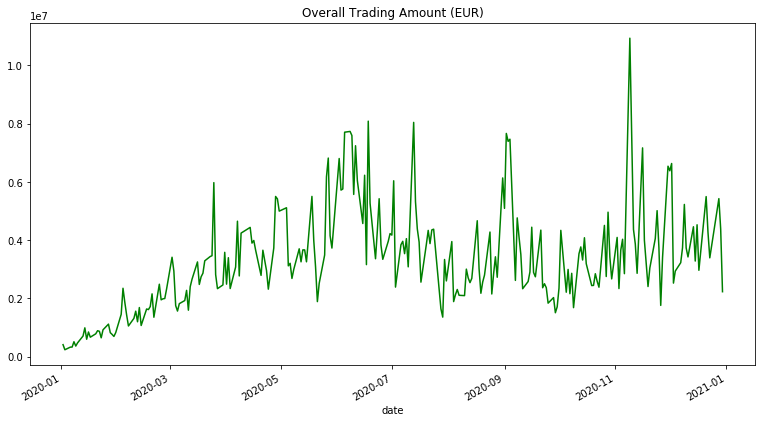

In [73]:
positions_date['abs MV'].plot(figsize=(13, 7), title='Overall Trading Amount (EUR)', color='green')


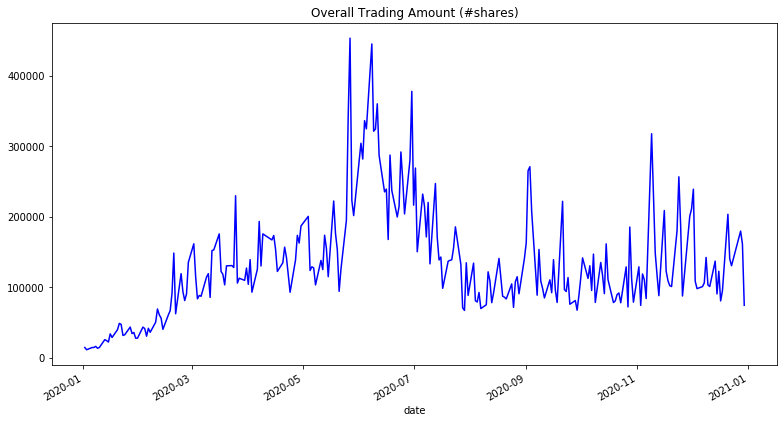

In [72]:
positions_date['execution_size'].plot(figsize=(13, 7), title='Overall Trading Amount (#shares)', color='blue')


## Technical Follow-up:

#### How would you improve the performance of the above steps given large-scale datasets?

The previous analysis is already data-heavy and requires some time to run queries or analysis (even in python versus Excel). Therefore, it is extremely important to find methods in order to handle large data amounts. The larger the volume of the data, the more the resources are required from hardware (memory, processors, and disks) to time and human capital (e.g. analysts). 

It is important to know very well what kind of data we are working with, how fast will it grow and how is it going to grow (e.g. different fields and databases needed). 

##### Loading: 
Load data incrementally: loading only the changes between the previous and the new data saves it is better to segment data that is essential for the data warehouse and load it in batches.
Use task scheduling to automatically load new data: usually better during the night/early morning (e.g. close/open market prices database update) so that network traffic and computer usage are at its minimum (this was we are not putting in risk other's work nor the ETL loading process).

##### Transformations: 
Automate transformation so that process runs more efficiently 
Eliminate database Reads/Writes
Use Parallel Processing
Early on the filter of Unnecessary Datasets - just like filtering the datasets in the workflow, it is also better to ignore unessential rows when dealing with data
Correct/standard labeling of column names and attributions - sector and country example mentioned above. 

##### Querying: 
Assuming we are under large datasets and relational databases, we will probably need SQL queries to, at least, extract the necessary information 
Set-based operations in SQL run usually faster than row-based executions of procedural languages: avoid unnecessary Joins and complex queries. 
Reduce data as early as possible
Automate cleaning and data transformation functions - in particular when it comes to data cleaning and handling, more similar to the analysis in this challenge ( e.g. in python)

Despite being important performance-improving techniques to be put in place, these are not long-term solutions for a company with billions of trades, hourly price information for 500k instruments over 5 years, and constantly growing. 

To do so, it is also essential that the data is load, clustered, and transformed on cloud services, in order to develop a more robust and safe high-performance process. These technologies not only allow to have more efficient and high-quality data saved into the data warehouse but also to run heavier machine learning algorithms (e.g. deep learning) for complex data structures. 

#### How would you test the correctness of each run?

It is becoming more difficult to test or verify results from analysis because input data size is increasing, with its applications and functionality becoming more and more complex. It is infeasible to completely test the entire system because there are too many possibilities, therefore it is important to perform several tests on the several stages of the process. 

Several checks should be put into place when it comes to complex and heavy data structures requiring a high level of data cleaning and handling. The following strategies are described with the techniques applied in this analysis as well:

- Harmonization Strategy checks: making sure all labels and categorical variables are saved and attributed correct value - country and sector example. 
- Null Values: check for values that shouldn't be Null and are, and vice versa - Simple "Sanity checks" - check null values for each column
- Implement simple tests at lower levels: increment testing. More frequent testing at the early stages of what is to become complex analysis will reduce the chances of having to deal with two or more errors at the same time, which can often generate, confusing and more serious errors. - performed checks before heavier joins and aggregation functions
- Business Intuition and benchmark comparison: does the performance make sense when compared to the overall market (e.g. benchmarked against S&P 500 2020 returns).   



## Part 2: Add API data

For this challenge, the first step is to connect to an API that provides daily FX rate information on the currencies presented. I  used exchangeratesapi.io which provides a free service for historical exchange rates (published by European Central Bank in JSON format). However, the time series option was not available for the free program so I wrote a loop function to get the 254 dates for 2020 (trading days) and append it into a dataframe:

In [74]:
import requests
import json
import pandas as pd
from requests.auth import HTTPBasicAuth #authentication code
from getpass import getpass

In [157]:
hist_rates

{'error': {'code': 'usage_limit_reached',
  'message': 'Your monthly usage limit has been reached. Please upgrade your Subscription Plan.'}}

In [158]:
#try with one date
api_key = '2f44fa73c1a0c5acd8c5f8426ffe4d34'
symbols = "USD,GBP,AUD,JPY,CNY,RUB,SEK,INR,BRL"
date = '2020-02-02'
hist_url ='http://api.exchangeratesapi.io/v1/'+date+'?access_key='+ api_key +'&symbols='+symbols+'&format=1'
response = requests.get(hist_url)
hist_rates = json.loads(response.text)
rates = pd.Series(hist_rates['rates'], name=date)
df = df.append(rates, sort=False )

df

,AUD,BRL,CNY,GBP,INR,JPY,RUB,SEK,USD
2020-02-02,1.656805,4.749384,7.692407,0.84131,79.288269,120.182222,70.868318,10.684303,1.108943
2020-02-02,1.656805,4.749384,7.692407,0.84131,79.288269,120.182222,70.868318,10.684303,1.108943


In [159]:
#get all dates for 2020
dates_2020 = list(positions_date.index.strftime('%Y-%m-%d').unique())

#build function 
def api_machine(dates):
    df = pd.DataFrame([])
    for date in dates:
        try:
            api_key = '2f44fa73c1a0c5acd8c5f8426ffe4d34'
            symbols = "USD,GBP,AUD,JPY,CNY,RUB,SEK,INR,BRL"
            hist_url ='http://api.exchangeratesapi.io/v1/'+date+'?access_key='+ api_key +'&symbols='+symbols+'&format=1'
            response = requests.get(hist_url)
            hist_rates = json.loads(response.text)
            rates = pd.Series(hist_rates['rates'], name=date)
            df = df.append(rates, sort=False)
        except ValueError:
            pass
    return df


In [160]:
rates_historical = api_machine(dates_2020)    

In [207]:
rates_historical

,date,AUD,BRL,CNY,GBP,INR,JPY,RUB,SEK,USD
0,2020-01-02,1.599448,4.496162,7.779846,0.849432,79.787978,121.254820,68.956920,10.462531,1.117088
1,2020-01-03,1.605883,4.538554,7.773503,0.853178,80.085325,120.622911,69.246469,10.489647,1.116000
2,2020-01-06,1.614037,4.547904,7.810650,0.850265,80.387465,121.379588,69.205813,10.530275,1.119650
3,2020-01-07,1.625938,4.537184,7.747022,0.850629,80.527623,120.488524,69.117870,10.563465,1.115418
4,2020-01-08,1.616745,4.516675,7.719162,0.848019,79.397352,121.166509,68.117886,10.505076,1.111278
...,...,...,...,...,...,...,...,...,...,...
249,2020-12-22,1.613756,6.288044,7.973844,0.909523,90.647598,126.175529,92.509825,10.148867,1.218628
250,2020-12-23,1.608443,6.359814,7.973791,0.902740,90.018652,126.246666,91.500050,10.105647,1.219103
251,2020-12-28,1.610726,6.413336,7.989600,0.907668,89.886359,126.734029,90.400108,10.115798,1.222193
252,2020-12-29,1.610136,6.383710,8.002126,0.907665,89.996202,126.888279,90.738150,10.054634,1.225257


In [267]:
trades_details.head()

,customer_id,date,direction,execution_size,execution_price,instrument_id,sector_name,country_name,index_name,instrument_type,MV,abs MV
385708,3764,2020-01-02,BUY,303.0,1.290,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,390.87,390.87
381784,3728,2020-01-02,BUY,4.0,67.730,592.0,Nahrung,USA,"""""",STOCK,270.92,270.92
339507,2116,2020-01-02,BUY,270.0,0.891,580.0,Industrie,Norwegen,"""""",STOCK,240.57,240.57
71405,155,2020-01-02,BUY,21.0,56.700,562.0,"""Large/Mid Caps""","""""","""""",ETF,1190.70,1190.70
378073,2116,2020-01-02,BUY,140.0,2.200,599.0,Energieversorgung,USA,"""""",STOCK,308.00,308.00


In [268]:
trades_details['digit'] = trades_details.index.astype(str).str[-1].astype(int)

#get costumer base currency
#Last digit Currency
code_currrency = {1:"USD",2:"GBP",3:"AUD",4:"JPY",5:"CNY",6:"RUB",7:"SEK", 8:"INR",9:"BRL",0:"MXN"}

#map with dict
trades_details['local currency'] = trades_details['digit'].map(code_currrency)

In [269]:
t = rates_historical.set_index('date').stack().reset_index(name='Rate').rename(columns={'level_1':'local currency'})
t['date'] = pd.to_datetime(t['date'])

In [271]:
#get rate for each day and currency 
trades_details = pd.merge(trades_details,t,how='inner',on=['local currency','date'])

trades_details['MV local currency'] = trades_details['MV'] *trades_details['Rate']
trades_details.head()

,customer_id,date,direction,execution_size,execution_price,instrument_id,sector_name,country_name,index_name,instrument_type,MV,abs MV,digit,local currency,Rate,MV local currency
0,3764,2020-01-02,BUY,303.0,1.290,576.0,"Computer,""Elektronik & Haushalt"",""Large Caps""",China,"""""",STOCK,390.870,390.870,8,INR,79.787978,31186.726961
1,3003,2020-01-02,BUY,225.0,0.892,580.0,Industrie,Norwegen,"""""",STOCK,200.700,200.700,8,INR,79.787978,16013.447185
2,3003,2020-01-02,BUY,31.0,6.494,1.0,"""""","""""","""""",STOCK,201.314,201.314,8,INR,79.787978,16062.437003
3,3242,2020-01-02,BUY,7.0,27.100,567.0,"""Large/Mid/Small Caps""","""""","""""",ETF,189.700,189.700,8,INR,79.787978,15135.779427
4,2606,2020-01-02,BUY,4.0,57.010,562.0,"""Large/Mid Caps""","""""","""""",ETF,228.040,228.040,8,INR,79.787978,18194.850503


In [274]:
positions_local = trades_details.groupby(['customer_id']).agg({'MV local currency':'sum','local currency': 'first'})

positions_local

,MV local currency,local currency
customer_id,,
1,6.340224e+04,CNY
2,7.272910e+03,SEK
3,2.166640e+05,JPY
4,1.172254e+04,RUB
5,1.117041e+06,USD
...,...,...
29996,-2.575911e+03,USD
29997,4.728931e+04,INR
29998,3.298411e+03,GBP
